In [1]:
from   astropy.table import Table
from   astropy.io    import fits
from   scripts.tools        import *
import matplotlib.pyplot as plt
import numpy as np
obj_lis  = Table.read('obj_lis_selected.fits')

### redshift of selected objs

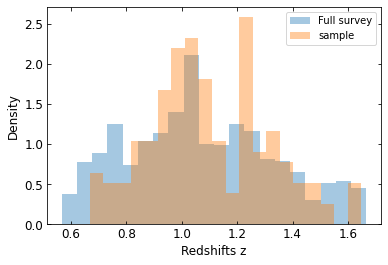

In [31]:
full_object_list = Table.read('full_object_catalog.fits')
obj_with_line = full_object_list[np.logical_and(full_object_list['Ha_FLUX']>0,full_object_list['Hb_FLUX']>0)]

plt.hist(obj_with_line['z_MAP'],bins=20,alpha=0.4,density=True,label='Full survey')
plt.hist(obj_lis['z_MAP'],bins=20,alpha=0.4,density=True,label='sample')
plt.xlabel('Redshifts z',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', top=True, right=True)
plt.legend()
plt.savefig('image_outputs/redshift_distribution.jpg',transparent=False)

In [26]:
#here we apply a correction of Nii for Ha +[NII] linemap
# #using Andreas L. Faisst 2018
def nii_ha_ratio(stellar_mass, redshift):
    """
    Calculate the [NII]/Hα flux ratio based on the empirical model by Faisst et al. (2018).
    
    Parameters:
    stellar_mass (float): Stellar mass of the galaxy (in solar masses)
    redshift (float): Redshift (z)
    
    Returns:
    float: Computed [NII]/Hα flux ratio
    """
    import numpy as np

    # Compute the scaled variables
    x = np.log10(stellar_mass) - 10.5
    y = redshift - 2.3

    # Apply the empirical relation
    log_nii_ha = -0.773 + 1.235 * x - 0.281 * x**2 - 0.020 * y + 0.019 * y**2

    # Convert log value to actual ratio
    return 10**log_nii_ha  


def nii_ha_ratio_zahid(stellar_mass, redshift):
    """
    Calculate the [NII]/Hα flux ratio based on the redshift-dependent empirical model by Zahid et al. (2014).

    Parameters:
    stellar_mass (float): Stellar mass of the galaxy (in solar masses)
    redshift (float): Redshift (z)

    Returns:
    float: Computed [NII]/Hα flux ratio
    """
    import numpy as np

    # Convert stellar mass to log scale
    logm = np.log10(stellar_mass)

    # Compute the redshift-dependent coefficient
    a_z = -1.32 + 0.4 * redshift

    # Apply Zahid et al. (2014) empirical relation
    log_nii_ha = a_z + 0.32 * (logm - 10) - 0.05 * (logm - 10)**2

    # Convert log value to actual ratio
    return 10**log_nii_ha



def NII_corr(obj):
    path = f"data_extracted/{file_name(obj,prefix='extracted')}"
    with fits.open(path,mode='update') as hdu:
        ha = find_data('LINE_HA',hdu)[1]
        if 'NII_corr' in ha.header:
            return f"{obj['subfield']}-{obj['ID']} already corrected"
        ha.name = 'LINE_HA'
        ratio = nii_ha_ratio_zahid(obj['mass'],obj['z_MAP'])
        ha.data = ha.data/(1+ratio)
        ha.header['NII_corr'] = str(round(ratio,8))
        save_update(ha,hdu)
        hdu.flush()
        return f"{obj['subfield']}-{obj['ID']} processed"

from    concurrent.futures  import ThreadPoolExecutor, as_completed
from    tqdm                import tqdm
def cat_process(obj_lis, max_threads=1):
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    NII_corr,
                    obj): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(NII_corr(obj))
            return results

def main():
    obj_lis = Table.read('obj_lis_selected.fits')
    
    results = cat_process(obj_lis,max_threads=5)
    errorcounting(results)
    print(results)

if __name__ == '__main__':
    main()


Processing:   0%|          | 0/393 [00:00<?, ?it/s]


KeyboardInterrupt: 

## SFMS

### the following is the SFMS model from eq3 of Whitaker 2014

In [ ]:
def whitaker_params(z):
    a = 0.7 - 0.13 * z  # Slope varies with redshift
    b = 1.13 + 0.12 * z  # Intercept varies with redshift
    return a, b

# SFMS for 0.5 < z < 1.0 (Whitaker+2014)
def z_05_10(m_array):
    z = 0.75  # Representative of 0.5 < z < 1.0
    a, b = whitaker_params(z)
    sfr = a * (m_array - 10.5) + b
    sfr_err = np.sqrt((0.09 * (m_array - 10.5))**2 + 0.04**2)  # Error calculation
    return sfr, sfr_err

# SFMS for 1.0 < z < 1.5 (Whitaker+2014)
def z_10_15(m_array):
    z = 1.25  # Representative of 1.0 < z < 1.5
    a, b = whitaker_params(z)
    sfr = a * (m_array - 10.5) + b
    sfr_err = np.sqrt((0.08 * (m_array - 10.5))**2 + 0.03**2)  # Error calculation
    return sfr, sfr_err

# Generate SFMS model
def SFMS_model(m_min, m_max):
    m = np.linspace(m_min, m_max, 100)
    sfr_1, sfr_1_err = z_05_10(m)
    sfr_2, sfr_2_err = z_10_15(m)

    data_points = np.array([
    [9.00985010706638, 0.3750833400895641],
    [9.198715203426124, 0.4684361631605811],
    [9.310492505353318, 0.5224858476843619],
    [9.406852248394005, 0.5863141027169592],
    [9.510920770877945, 0.6501528497779989],
    [9.603426124197002, 0.7678734089077328],
    [9.672805139186295, 0.8316649418407791],
    [9.807708779443255, 0.9200445434298445],
    [9.923340471092077, 1.0083979149478028],
    [10.058244111349037, 1.1457752893653756],
    [10.220128479657387, 1.1900936175083348],
    [10.408993576017131, 1.2834464405793513],
    [10.759743040685226, 1.4505162554904314]])
    m,sfr = data_points.reshape(-1,2).transpose()
    err = 0.6539 - sfr[0]
    sfr_1_l, sfr_1_h = sfr - err, sfr + err

    sfr_1_l, sfr_1_h = sfr_1 - sfr_1_err, sfr_1 + sfr_1_err
    sfr_2_l, sfr_2_h = sfr_2 - sfr_2_err, sfr_2 + sfr_2_err



    return m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h




### SFMS of selected objects

C:\Users\26715\AppData\Local\Temp\ipykernel_50068\987121503.py:1: RuntimeWarning: invalid value encountered in log10
  logmass = np.log10(obj_lis['mass'])
C:\Users\26715\AppData\Local\Temp\ipykernel_50068\987121503.py:2: RuntimeWarning: invalid value encountered in log10
  logsfr  = np.log10(obj_lis['sfr'])
C:\Users\26715\AppData\Local\Temp\ipykernel_50068\987121503.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(full_cat['mass']),
C:\Users\26715\AppData\Local\Temp\ipykernel_50068\987121503.py:18: RuntimeWarning: invalid value encountered in log10
  ax.scatter(np.log10(full_cat['mass']),
C:\Users\26715\AppData\Local\Temp\ipykernel_50068\987121503.py:19: RuntimeWarning: divide by zero encountered in log10
  np.log10(full_cat['sfr']),
C:\Users\26715\AppData\Local\Temp\ipykernel_50068\987121503.py:19: RuntimeWarning: invalid value encountered in log10
  np.log10(full_cat['sfr']),


<Figure size 720x432 with 0 Axes>

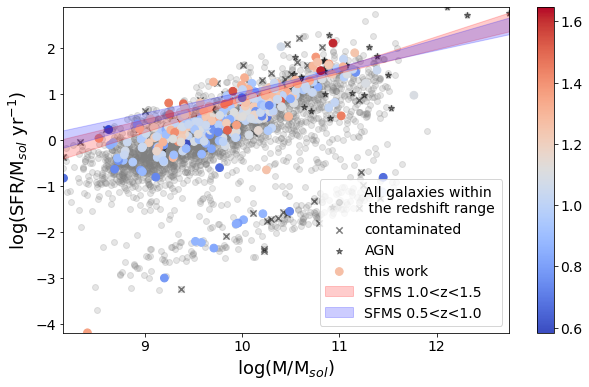

In [27]:
logmass = np.log10(obj_lis['mass'])
logsfr  = np.log10(obj_lis['sfr'])
agn     = obj_lis['tag'] == 'agn'
contam  = np.logical_and(obj_lis['manual_select'] == 'selected', np.logical_not(agn))
sample  = np.logical_and(np.logical_not(agn), np.logical_not(contam))

plt.figure(figsize=(10, 6))

# 使用颜色映射
cmap = plt.get_cmap('coolwarm')  # 更换为深色的颜色映射
norm = plt.Normalize(vmin=np.min(obj_lis['z_MAP']), vmax=np.max(obj_lis['z_MAP']))

fig, ax = plt.subplots(figsize=(10, 6))

full_cat = Table.read('full_object_catalog.fits')
mask  = np.logical_and(full_cat['z_MAP'] > np.min(obj_lis['z_MAP']), full_cat['z_MAP'] < np.max(obj_lis['z_MAP']))
full_cat = full_cat[mask]
ax.scatter(np.log10(full_cat['mass']),
            np.log10(full_cat['sfr']),
            color='grey', alpha=0.2, label='All galaxies within \n the redshift range')
ax.scatter(logmass[contam], logsfr[contam], color='black', marker='x', label='contaminated', s=40, alpha=0.5)
ax.scatter(logmass[agn], logsfr[agn], color='black', marker='*', label='AGN', s=40, alpha=0.5)
sc = ax.scatter(logmass[sample], logsfr[sample], c=obj_lis['z_MAP'][sample], cmap=cmap, norm=norm, label='this work', s=60)

ax.set_xlim(np.nanmin(logmass), np.nanmax(logmass))
ax.set_ylim(np.nanmin(logsfr), np.nanmax(logsfr))

m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h = SFMS_model(np.nanmin(logmass), np.nanmax(logmass))
ax.fill_between(m, sfr_1_l, sfr_1_h, color="r", alpha=0.2, label='SFMS 1.0<z<1.5')
ax.fill_between(m, sfr_2_l, sfr_2_h, color="b", alpha=0.2, label='SFMS 0.5<z<1.0')

ax.legend(fontsize=14, loc='lower right')
ax.set_xlabel(r'log(M/M$_{sol}$)', fontsize=18)
ax.set_ylabel(r'log(SFR/M$_{sol}$ yr$^{-1}$)', fontsize=18)
#ax.set_title('Star Formation Main Sequence', fontsize=20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Redshift (z)', fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.savefig('image_outputs/sfms.jpg',dpi=300)
plt.show()


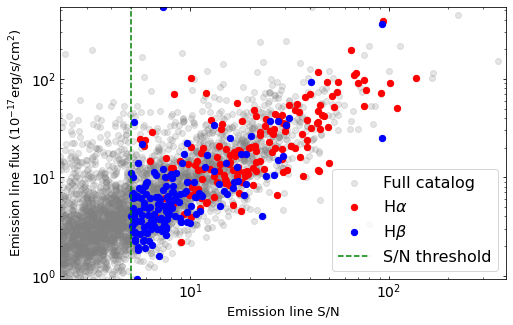

In [32]:
line_flux_ha = obj_lis['Ha_FLUX']
line_flux_hb = obj_lis['Hb_FLUX']
sn_ha = obj_lis['sn_ha']
sn_hb = obj_lis['sn_hb']
full_cat_sn_ha = full_object_list['Ha_FLUX']/full_object_list['Ha_FLUX_ERR']
full_cat_sn_hb = full_object_list['Hb_FLUX']/full_object_list['Hb_FLUX_ERR']

plt.figure(figsize=(8, 5))

plt.scatter(full_cat_sn_ha, full_object_list['Ha_FLUX'], color='grey', alpha=0.2, label='Full catalog')
plt.scatter(full_cat_sn_hb, full_object_list['Hb_FLUX'], color='grey', alpha=0.2)
plt.scatter(sn_ha, line_flux_ha, color='r', s=40, label=r'H$\alpha$')
plt.scatter(sn_hb, line_flux_hb, color='b', s=40, label=r'H$\beta$')

plt.axvline(x=5, color='green', linestyle='--', label='S/N threshold')

plt.xscale('log')
plt.yscale('log')
plt.xlim(np.nanmin(line_flux_ha), np.nanmax(line_flux_ha))
plt.ylim(np.nanmin(line_flux_hb), np.nanmax(line_flux_hb))
plt.xlabel('Emission line S/N', fontsize=13)
plt.ylabel(r'Emission line flux ($10^{-17}$erg/s/cm$^2$)', fontsize=13)
plt.legend(fontsize=16)

# 设置刻度线朝内
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('image_outputs/sn_line_flux.jpg', dpi=300)
plt.show()

C:\Users\26715\AppData\Local\Temp\ipykernel_45588\1127101313.py:1: RuntimeWarning: invalid value encountered in log10
  logmass = np.log10(obj_lis['mass'])
C:\Users\26715\AppData\Local\Temp\ipykernel_45588\1127101313.py:2: RuntimeWarning: invalid value encountered in log10
  logsfr  = np.log10(obj_lis['sfr'])
C:\Users\26715\AppData\Local\Temp\ipykernel_45588\1127101313.py:16: RuntimeWarning: divide by zero encountered in log10
  sc = ax.scatter(np.log10(full_cat['mass']),
C:\Users\26715\AppData\Local\Temp\ipykernel_45588\1127101313.py:16: RuntimeWarning: invalid value encountered in log10
  sc = ax.scatter(np.log10(full_cat['mass']),
C:\Users\26715\AppData\Local\Temp\ipykernel_45588\1127101313.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(full_cat['sfr']),
C:\Users\26715\AppData\Local\Temp\ipykernel_45588\1127101313.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(full_cat['sfr']),


<Figure size 720x432 with 0 Axes>

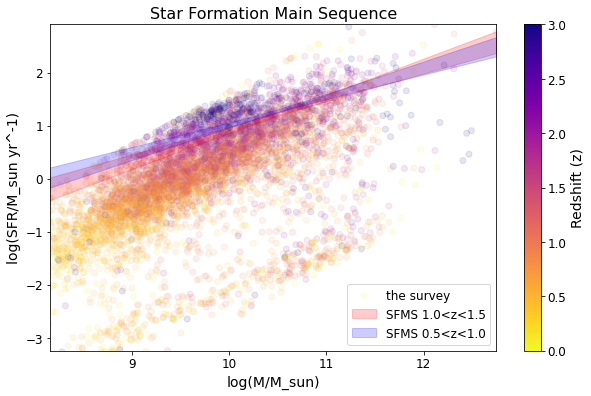

In [ ]:
logmass = np.log10(obj_lis['mass'])
logsfr  = np.log10(obj_lis['sfr'])
agn     = obj_lis['tag'] == 'agn'
contam  = np.logical_and(obj_lis['manual_select'] == 'selected', np.logical_not(agn))
sample  = np.logical_and(np.logical_not(agn), np.logical_not(contam))

plt.figure(figsize=(10, 6))

# 使用颜色映射
cmap = plt.get_cmap('plasma_r')  # 更换为深色的颜色映射
full_cat = Table.read('full_object_catalog.fits')
norm = plt.Normalize(vmin=0, vmax=3)

fig, ax = plt.subplots(figsize=(10, 6))

sc = ax.scatter(np.log10(full_cat['mass']),
                np.log10(full_cat['sfr']),
                c=full_cat['z_MAP'],
                cmap=cmap, norm=norm, alpha=0.1, label='the survey')

ax.set_xlim(np.nanmin(logmass), np.nanmax(logmass))
ax.set_ylim(np.nanmin(logsfr), np.nanmax(logsfr))

m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h = SFMS_model(np.nanmin(logmass), np.nanmax(logmass))
ax.fill_between(m, sfr_1_l, sfr_1_h, color="r", alpha=0.2, label='SFMS 1.0<z<1.5')
ax.fill_between(m, sfr_2_l, sfr_2_h, color="b", alpha=0.2, label='SFMS 0.5<z<1.0')

ax.legend(fontsize=12, loc='lower right')
ax.set_xlabel('log(M/M_sun)', fontsize=14)
ax.set_ylabel('log(SFR/M_sun yr^-1)', fontsize=14)
ax.set_title('Star Formation Main Sequence', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Redshift (z)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.show()


C:\Users\26715\AppData\Local\Temp\ipykernel_50068\3795769659.py:5: RuntimeWarning: invalid value encountered in log10
  y = np.log10(obj_lis['OIII_FLUX']/obj_lis['Hb_FLUX'])
C:\Users\26715\AppData\Local\Temp\ipykernel_50068\3795769659.py:6: RuntimeWarning: invalid value encountered in log10
  x = np.log10(obj_lis['SII_FLUX']/obj_lis['Ha_FLUX'])


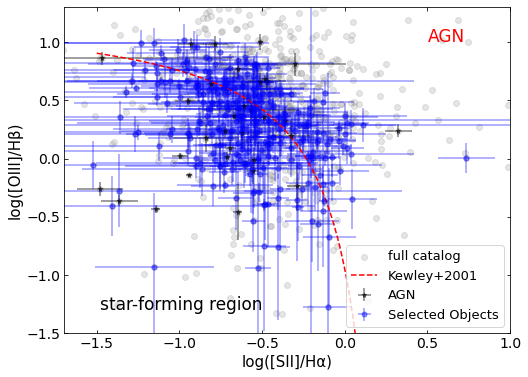

In [29]:
# Apply mask to filter out objects with any flux less than 0 in the full catalog
mask = (full_cat['OIII_FLUX'] > 0) & (full_cat['Hb_FLUX'] > 0) & (full_cat['SII_FLUX'] > 0) & (full_cat['Ha_FLUX'] > 0)
filtered_full_cat = full_cat[mask]

y = np.log10(obj_lis['OIII_FLUX']/obj_lis['Hb_FLUX'])
x = np.log10(obj_lis['SII_FLUX']/obj_lis['Ha_FLUX'])
agn = obj_lis['tag'] == 'agn'
select = obj_lis['manual_select'] == 'keep'

# Error propagation for log ratios
def error_propagation(flux1, flux2, flux1_err, flux2_err):
    return np.sqrt((flux1_err / (flux1 * np.log(10)))**2 + (flux2_err / (flux2 * np.log(10)))**2)

# Assuming flux errors are available in the table
OIII_FLUX_err = obj_lis['OIII_FLUX_ERR']
Hb_FLUX_err = obj_lis['Hb_FLUX_ERR']
SII_FLUX_err = obj_lis['SII_FLUX_ERR']
Ha_FLUX_err = obj_lis['Ha_FLUX_ERR']

y_err = error_propagation(obj_lis['OIII_FLUX'], obj_lis['Hb_FLUX'], OIII_FLUX_err, Hb_FLUX_err)
x_err = error_propagation(obj_lis['SII_FLUX'], obj_lis['Ha_FLUX'], SII_FLUX_err, Ha_FLUX_err)


fig, ax = plt.subplots(figsize=(8, 6))

plt.scatter(np.log10(filtered_full_cat['SII_FLUX']/filtered_full_cat['Ha_FLUX']),
            np.log10(filtered_full_cat['OIII_FLUX']/filtered_full_cat['Hb_FLUX']),
            color='grey', alpha=0.2, label='full catalog')

plt.errorbar(x[agn], y[agn], xerr=x_err[agn], yerr=y_err[agn], fmt='*', color='black', label='AGN', markersize=5, alpha=0.5)
plt.errorbar(x[~agn], y[~agn], xerr=x_err[~agn], yerr=y_err[~agn], fmt='o', color='blue', label='Selected Objects', markersize=5, alpha=0.4)

# Kewley 2001 theoretical demarcation line for BPT diagram
def kewley01_sii(x):
    return 0.72 / (x - 0.32) + 1.30

x_vals = np.linspace(-1.5, 0.3, 400)
y_vals = kewley01_sii(x_vals)

plt.plot(x_vals, y_vals, 'r--', label='Kewley+2001')
plt.xlabel('log([SII]/Hα)', fontsize=15)
plt.ylabel('log([OIII]/Hβ)', fontsize=15)
plt.legend(loc='lower right', fontsize=13)


# Add text to the plot
plt.text(-1.48, -1.3, 'star-forming region', fontsize=17, color='black')
plt.text(0.5, 1.0, 'AGN', fontsize=17, color='red')

plt.xlim(-1.7, 1)
plt.ylim(-1.5, 1.3)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('image_outputs/bpt.jpg', dpi=300)
plt.show()

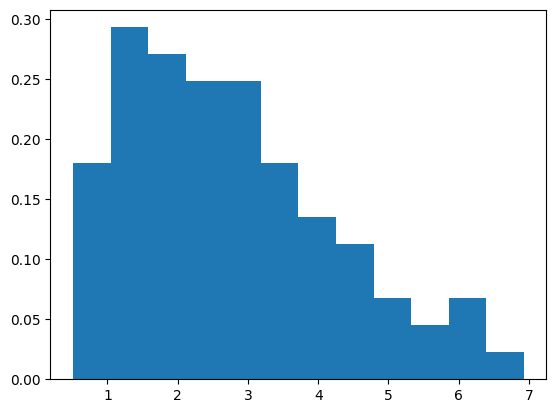

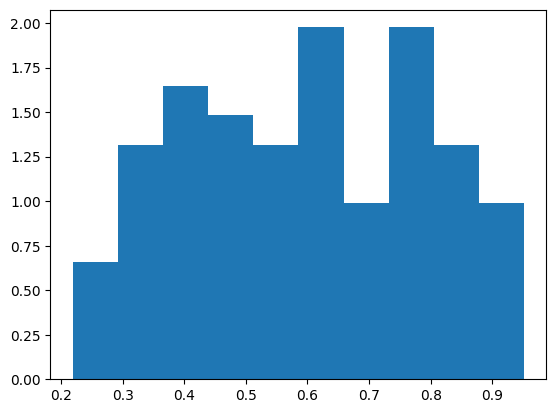

In [278]:
plt.hist(obj_lis[select]['re']*obj_lis[select]['pixel_length']/0.1,bins=12,density=True,alpha=1,label='selected objs')
#obj_lis['q] is the ratio of the semi-minor axis to the semi-major axis of the ellipse
plt.show()
plt.hist(obj_lis[select]['q'],bins=10,density=True,alpha=1,label='selected objs')
plt.show()